In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, ZeroPadding2D, Input, MaxPool2D, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

2024-04-23 01:22:36.265157: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 01:22:36.329457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
torch.cuda.is_available()

Num GPUs Available:  8


True

In [13]:
TRAINING_DIR = '/usr/cs/grad/masters/2026/kbhagat/MLProject/train/'
VALIDATION_DIR = '/usr/cs/grad/masters/2026/kbhagat/MLProject/valid/'
TESTING_DIR = '/usr/cs/grad/masters/2026/kbhagat/MLProject/test/'
BATCH_SIZE = 16
INPUT_SHAPE = (224, 224)
SEED = 777
EPOCHS = 2
GROW_RATE = 16
BASE_FILTERS = 12
NUM_CLASSES = 525
IMAGES_SHAPE = (224, 224, 3)

In [14]:
tf.random.set_seed(SEED)

Found 13670 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 13670 images belonging to 525 classes.
Batch index: 731


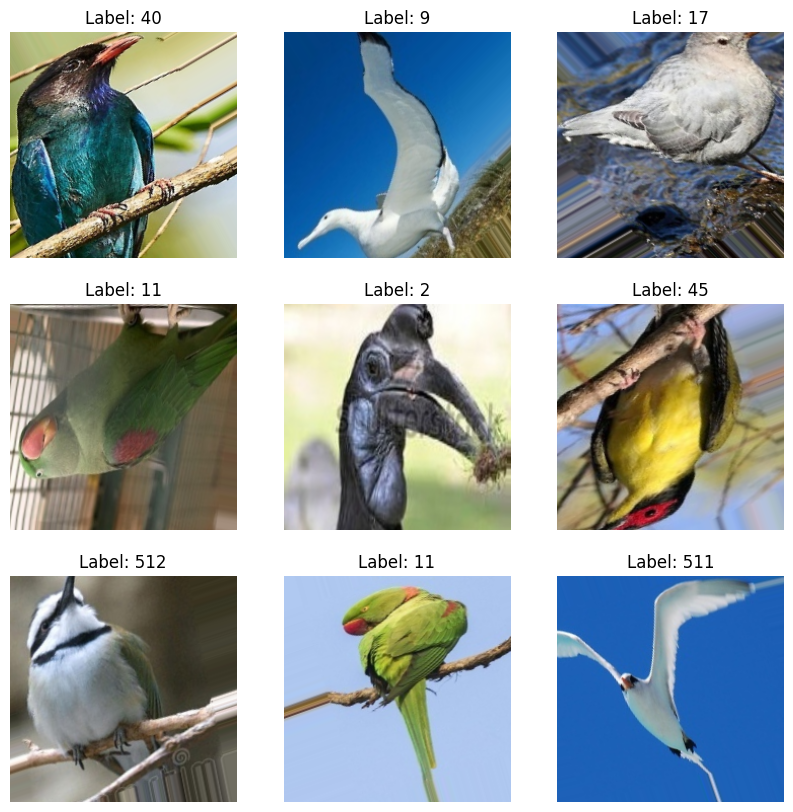

In [15]:
training_gen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    rotation_range=40
)
training_set = training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE, 
    class_mode='categorical'
)
validation_gen = ImageDataGenerator(rescale=1./255)
validation_set = validation_gen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE, 
    class_mode='categorical'
)

testing_gen = ImageDataGenerator(rescale=1./255)
testing_set = testing_gen.flow_from_directory(
    TESTING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE, 
    class_mode='categorical'
)
# Generating images
generated_images = next(training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=9,
    target_size=INPUT_SHAPE,
    class_mode=None,
    shuffle=False
))

def decode_one_hot(labels):
    return [label.argmax() for label in labels]

# Choose a random batch index from the dataset
batch_index = random.randint(0, len(training_set) - 1)
print("Batch index:", batch_index)

# Retrieve the batch of images and labels
random_images, random_labels = training_set[batch_index]

# Decode the one-hot encoded labels
random_labels = decode_one_hot(random_labels)

# Limit the number of images to display to 9
num_images_to_display = min(len(random_images), 9)

# Display the random images with their corresponding class labels
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_images[i])
    plt.title(f"Label: {random_labels[i]}")
    plt.axis("off")
plt.show()

In [16]:
class LearningRateDecay(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        if epoch < 25 and epoch % 2 == 0:
            return
        else:
            self.model.optimizer.learning_rate = self.model.optimizer.learning_rate * tf.math.exp(-0.1)

class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['val_accuracy'] > 0.95:
            self.model.stop_training = True
            print('Early Stopping !, learning rate now is {}'.format(self.model.optimizer.learning_rate))

In [17]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        self.filters = filters
        self.bn = BatchNormalization()
        self.activation = ReLU()
        self.Conv_1 = Conv2D(filters, 1)
        self.Conv_3 = Conv2D(filters, 3, padding='same')

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.activation(x)
        x = self.Conv_1(x)
        x = self.Conv_3(x)
        return x

In [18]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DenseBlock, self).__init__()
        self.conv_block = ConvBlock(filters)
        self.cont = Concatenate(axis=-1)

    def call(self, x, num_conv_block):
        inputs = [x]
        inputs.append(self.conv_block(x))
        for i in range(num_conv_block - 1):
            x = self.cont(inputs)
            x = self.conv_block(x)
            inputs.append(x)

        x = self.cont(inputs)
        return x

In [19]:
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(TransitionBlock, self).__init__()
        self.bn = BatchNormalization()
        self.activation = ReLU()
        self.conv_1 = Conv2D(filters, 1)
        self.avgpooling = AveragePooling2D(pool_size=2, strides=2)

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.activation(x)
        x = self.conv_1(x)
        x = self.avgpooling(x)
        return x

In [20]:
class DenseNet(tf.keras.Model):
    def __init__(self, grow_rate, base_dims, num_classes, input_shape):
        super(DenseNet, self).__init__()
        print("Input shape:", input_shape)
        self.grow_rate = grow_rate
        #self.base_dims = base_dims
        self.inputs = Input(shape=input_shape)
        self.conv_7 = Conv2D(base_dims, kernel_size=7, strides=2, padding='same')
        # print("conv_7 output shape:", self.conv_7.output_shape)  # Remove this line
        self.bn = BatchNormalization()
        self.activation = ReLU()
        self.max_pooling = MaxPooling2D(pool_size=3, strides=2, padding='same')
        self.glob_avg_pool = GlobalAveragePooling2D()
        self.classifier = Dense(num_classes, activation='softmax')


    def call(self):
        num_conv_block = [6, 12, 24, 16]
        x = self.conv_7(self.inputs)
        x = self.bn(x)
        x = self.activation(x)
        x = self.max_pooling(x)
        for i in range(4):
            dims = self.base_dims + i * self.grow_rate
            x = DenseBlock(dims)(x, num_conv_block[i])
            if i != 3:
                x = TransitionBlock(dims)(x)

        x = self.glob_avg_pool(x)
        classifier = self.classifier(x)

        return tf.keras.Model(inputs=self.inputs, outputs=classifier)

In [21]:
EPOCHS = 2
GROW_RATE = 16
BASE_FILTERS = 12
NUM_CLASSES = 525
IMAGES_SHAPE = (224, 224, 3)

In [ ]:
lr = 0.0001

model = DenseNet(GROW_RATE, base_dims=BASE_FILTERS, num_classes=NUM_CLASSES, input_shape=IMAGES_SHAPE)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_set,
        # steps_per_epoch = len(training_set),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data =validation_set,
        # validation_steps = int(0.25*len(validation_set))
        )
model.evaluate(testing_set)
# Plot the training and validation accuracy and loss


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined